In [1]:
import numpy as np
import pandas as pd

from mesa.space import SingleGrid
from tqdm import tqdm

def create_grid(x, y):
    grid = SingleGrid(x, y, True)
    
    return grid

def make_network(grid, target_degree, neighbor_frac, seed = None):
    '''
    Replaces the network function from the original code. Uses built in get_neighborhood from mesa. 
    Returns transition matrix T instead of a df of neighbors, which is more akin to the original code. 
    Also uses helper funcs to_coord and to_index, defined within the scope of the function. 
    Should check the order of agents in the grid, confirm the helpers are indexing correctly. 
    Grid only exists to get neighborhood. 
    '''
    
    #Returns 0 - X as x coordinate. Indexing is done in row order
    to_coord = lambda x, X: (x % X, x // X)
    #goes over y rows, then adds x
    to_index = lambda x, X, y: x + y * X
    
    links = 0
    avg_degree = 0
    T = np.zeros((10000, 10000))
    pairs = []
    
    np.random.seed(seed)
    
    while avg_degree < target_degree:
        c1 = np.random.randint(10000)
        c1_coords = to_coord(c1, 100)
        neighs = grid.get_neighborhood(c1_coords, True, include_center = False, radius = 3)
        neigh_inds = [to_index(x, 100, y) for x, y in neighs]
        if np.random.rand() < neighbor_frac:
            pots = neigh_inds
        else:
            neigh_incl = neigh_inds + [c1]
            pots = [x for x in range(10000) if x not in neigh_incl]
            
        c2 = np.random.choice(pots)
        if T[c1, c2] == 0:
            pairs.append((c1, c2))
            T[c1, c2] = 1
            T[c2, c1] = 1
            links += 2
            avg_degree = links/10000
            if links % 10000 == 0:
                print(links)
                
    return T, pairs

grid = SingleGrid(100, 100, True)
T, pairs = make_network(grid, 20, 0.3)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


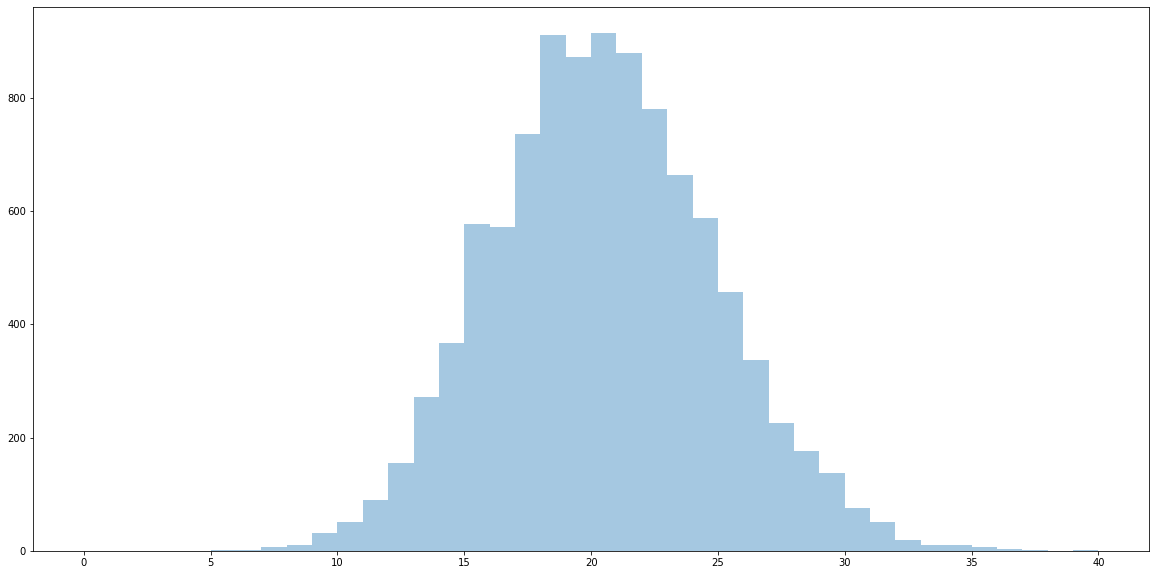

In [3]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize = (20, 10))

bins = np.linspace(0, 40, num = 41)
sns.distplot(T.sum(axis = 1), bins = bins, kde = False)

In [23]:
def assign_types(grid, stigma_frac, conform_frac):
    '''
    Replaces typestatus function in the original code. 
    Instead of using 0, 1, 2 as our types we use the written form.
    0 : Conformist, 1 : Stigmatized, 2 : Compassionate
    '''
    n = grid.height * grid.width
    stigs = np.random.choice(n, int(n * stigma_frac), replace = False)
    non_stigs = np.array([x for x in range(n) if x not in stigs])
    
    confs = np.random.choice(non_stigs, int(len(non_stigs) * conform_frac), replace = False)
    
    types = pd.DataFrame(index = np.arange(n))
    types['Type'] = 'Compassionate'
    types.loc[confs, 'Type'] = 'Conformist'
    types.loc[stigs, 'Type'] = 'Stigmatized'
    
    return types

def initial_status(revealed_frac, accepting_frac, types, threshs):
    '''
    Handles the initialization portion of the original evolve function. 
    '''
    stigs = types.query('Type == "Stigmatized"')
    comps = types.query('Type == "Compassionate"')
    
    revealed = np.random.choice(stigs.index, int(revealed_frac * len(stigs)), replace = False)
    accepting = np.random.choice(comps.index, int(accepting_frac * len(comps)), replace = False)
    
    types['Status'] = False
    types.loc[revealed, 'Status'] = True
    types.loc[accepting, 'Status'] = True
    types['Thresh'] = types['Type'].map(threshs)
    
    return types
    
types = assign_types(grid, 0.1, 0.3)
types = initial_status(0.15, 0.05, types, {'Compassionate' : 0.05, 'Stigmatized' : 0.4, 'Conformist' : 0.3})
types['N_Neighbors'] = T.sum(axis = 1)
types['N_Convert'] = types['N_Neighbors'] * types['Thresh']
types.head()

,Type,Status,Thresh,N_Neighbors,N_Convert
0,Compassionate,False,0.05,24.0,1.2
1,Compassionate,False,0.05,16.0,0.8
2,Conformist,False,0.30,24.0,7.2
3,Stigmatized,False,0.40,21.0,8.4
4,Compassionate,False,0.05,20.0,1.0


In [25]:
def step(init_info, T, status):
    '''
    Individual iteration of the main loop in evolve. 
    '''
    
    stigs = init_info.query('Type == "Stigmatized"').index
    comps = init_info.query('Type == "Compassionate"').index
    
    acc_neighbors = T @ status
    rev_neighbors = T[:, stigs] @ status[stigs]
    
    num_eff = acc_neighbors.copy()
    num_eff[comps] = rev_neighbors[comps]
    
    return pd.DataFrame({'Accepting' : acc_neighbors, 'Revealed' : rev_neighbors})

ret = step(types, T, types['Status'])

In [29]:
ret['Revealed'] > types['N_Convert']

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Length: 10000, dtype: bool